#  Modélisation par transformer 

## Pré-traitement

In [35]:
# Import des packages
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, LSTM, Dense, RNN, Lambda, Embedding

import unicodedata
import re
import os
import io
import time

import random

# -*- coding: utf-8 -*-

In [2]:
# Importation des données 
fr = pd.read_csv('french.txt', sep = "\n\n", names = ["Français"], encoding ='utf-8', engine = 'python')
en = pd.read_csv('english.txt', sep = "\n\n", names = ["English"], encoding ='utf-8', engine = 'python')
data = pd.concat([en, fr], axis=1)
data.tail()

,English,Français
154878,"""Top-down economics never works,"" said Obama. ...","« L'économie en partant du haut vers le bas, ç..."
154879,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
154880,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
154881,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
154882,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...


In [3]:
# Nettoyage des données 

def clean_sentence(w):

    # séparation entre un mot et sa ponctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    return w

# Appliquer la fonction clean_sentence sur la colonne english
data.English = data.English.apply(lambda x: clean_sentence(x))

# Appliquer la fonction clean_sentence sur la colonne french
data.Français = data.Français.apply(lambda x: clean_sentence(x))

corpus_en=[]
corpus_fr=[]

for sentences in data.English: 
    corpus_en.append(sentences)

for sentences in data.Français: 
    corpus_fr.append(sentences)

# Vérification 
#print(corpus_en[:5])
#print(corpus_fr[:5])

In [4]:
# Nombre de mots maximum par phrases
max_words_en = 0
max_words_fr = 0
for i in range(data.shape[0]):
    max_words_en = max(len(corpus_en[i].split()), max_words_en)
    max_words_fr = max(len(corpus_fr[i].split()), max_words_fr)

print("Nombre de mots maximum dans les phrases françaises :", max_words_fr)
print("Nombre de mots maximum dans les phrases anglaises :", max_words_en)

# Taille des vocabulaires
words_en = []
for i in range(data.shape[0]):
    for j in range(len(corpus_en[i].split())):
        if corpus_en[i].split()[j] not in words_en:
            words_en.append(corpus_en[i].split()[j])
            
words_fr = []
for i in range(data.shape[0]):
    for j in range(len(corpus_fr[i].split())):
        if corpus_fr[i].split()[j] not in words_fr:
            words_fr.append(corpus_fr[i].split()[j])
            
print("\nTaille du vocabulaire français :", len(words_fr))
print("Taille du vocabulaire anglais :", len(words_en))

Nombre de mots maximum dans les phrases françaises : 58
Nombre de mots maximum dans les phrases anglaises : 48

Taille du vocabulaire français : 30661
Taille du vocabulaire anglais : 16122


In [5]:
# Tokenisation

# Création des tokenizers
tokenizer_en = Tokenizer(num_words = 32000) # seuil fixé bien au-dessus des 16500 mots uniques
tokenizer_fr = Tokenizer(num_words = 32000)# seuil fixé bien au-dessus des 31000 mots uniques

# Génération des vocabulaires francais et anglais: 
    #permet de corréler chaque mot unique à un nombre 
tokenizer_fr.fit_on_texts(corpus_fr) 
tokenizer_en.fit_on_texts(corpus_en)

# Transformation des corpus en une liste de listes de nombres (correspondant chacun à un mot unique)
tokenized_fr = tokenizer_fr.texts_to_sequences(corpus_fr)
tokenized_en = tokenizer_en.texts_to_sequences(corpus_en)

# Vérification 
#print(tokenized_fr[:10])

In [6]:
# Ajout d'un token de début et d'un token de fin pour chaque phrase (liste) de la liste globale
new_fr = []
new_en = []

for sentence_fr, sentence_en in zip(tokenized_fr, tokenized_en):
    new_sentence_fr = [32000] + sentence_fr + [32001]
    new_sentence_en = [32000] + sentence_en + [32001]
    new_fr.append(new_sentence_fr)
    new_en.append(new_sentence_en)

tokenized_fr = new_fr
tokenized_en = new_en

# Vérification 
#n = np.random.randint(100)
#tokenized_fr[n]

In [7]:
# Vérification de la longueur des phrases

lengths_fr = []
lengths_en = []

for sentence_fr, sentence_en in zip(tokenized_fr, tokenized_en):
    lengths_fr.append(len(sentence_fr))
    lengths_en.append(len(sentence_en))
    
print("Longueur maximale FR:", max(lengths_fr))
print("Longueur maximale EN:", max(lengths_en))
print()
print("Taille Corpus FR:", len(tokenized_fr))
print("Taille Corpus EN:", len(tokenized_en))


Longueur maximale FR: 56
Longueur maximale EN: 46

Taille Corpus FR: 154883
Taille Corpus EN: 154883


In [8]:
# Padding: objectif les phrases tokenisées doivent avoir la même longueur (65 mots)

MAX_LENGTH = 60

new_fr = []
new_en = []

for sentence_fr, sentence_en in zip(tokenized_fr, tokenized_en):
    new_fr.append(sentence_fr + [0] * (MAX_LENGTH - len(sentence_fr)))
    new_en.append(sentence_en + [0] * (MAX_LENGTH - len(sentence_en)))
    
tokenized_fr = new_fr
tokenized_en = new_en

# Vérifications

# longueur des phrases 
for sentence_fr, sentence_en in zip(tokenized_fr, tokenized_en):
    if len(sentence_fr) != MAX_LENGTH or len(sentence_en) != MAX_LENGTH:
        print("Les phrases n'ont pas la bonne longueur.")
        break

# vérification du dernier nombre 
sample_sentence = tokenized_fr[0]
if len(sample_sentence) == MAX_LENGTH and sample_sentence[-1] != 0:
    print("Le token de padding utilisé n'est pas le bon.")


## Entrainement 

In [9]:
# Création de train_dataset (tensor_slices permet de découper la liste de listes)
X_train, X_test, y_train, y_test = train_test_split(tokenized_en, tokenized_fr,test_size=0.2)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)

In [10]:
# fonction iter() renvoie l'objet itérateur qui parcourt chaque élément de la liste.
# la fonction next() renvoit l'élément suivant
fr_batch, en_batch = next(iter(train_dataset))
fr_batch, en_batch

(<tf.Tensor: shape=(64, 60), dtype=int32, numpy=
 array([[32000,     1,    92, ...,     0,     0,     0],
        [32000,     5,   113, ...,     0,     0,     0],
        [32000,    40,   138, ...,     0,     0,     0],
        ...,
        [32000,     1,    16, ...,     0,     0,     0],
        [32000,     1,    77, ...,     0,     0,     0],
        [32000,     1,   106, ...,     0,     0,     0]])>,
 <tf.Tensor: shape=(64, 60), dtype=int32, numpy=
 array([[32000,     1,    73, ...,     0,     0,     0],
        [32000,    16,   148, ...,     0,     0,     0],
        [32000, 26680,     2, ...,     0,     0,     0],
        ...,
        [32000,   373,    72, ...,     0,     0,     0],
        [32000,    21,    89, ...,     0,     0,     0],
        [32000,     1,    23, ...,     0,     0,     0]])>)

## Génération de masques

In [11]:
# Création du look-ahead mask qui permet de masquer les fins de la phrase traduite 
# pour obtenir des phrases partiellement traduites qui seront utilisées dans le décodeur 
# concrètement, le masque cache les tokends strictement au-dessus de la diagonale. 
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (size, size)

# Vérifications 
#create_look_ahead_mask(MAX_LENGTH)

In [12]:
# Création du masque de padding
# permet d'empêcher que les mécanismes prêtent attention aux tokens de padding

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # tf.cast fait passer de x (tenseur) à dtype
    # tf.math.equal(seq, 0): permet de vérifier si la sequence seq est égale à 0

    # ajouter de deux dimensions avant et après pour obtenir le bon nombre de dimensions (batch_size, 1, 1, seq_len)
    return seq[:, tf.newaxis, tf.newaxis, :]

# Vérifications
#x = tf.constant([[7, 6, 0, 0, 1],
#                 [1, 2, 3, 0, 0],
#                 [0, 0, 0, 4, 5]])

#mask = create_padding_mask(x)
#mask

In [13]:
def create_masks(inp, tar):
    # Encodage du masque de padding de l'entrée du décodeur 
    enc_padding_mask = create_padding_mask(inp)

    # Masque de padding utilisé dans le bloc décodeur - second attention 
    # permet depour cacher une partie des sorties de l'encodeur 
    dec_padding_mask = create_padding_mask(inp)

    # Masque de padding utilisé dans le bloc de décodeur - première attention  
    # permet de cacher la fin des phrases traduites 
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

## Entrainement d'un transformer pour la traduction

In [14]:
%run Transformeur.ipynb

num_layers = 1
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_en.num_words + 2
target_vocab_size = tokenizer_fr.num_words + 2
dropout_rate = 0.1


transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

Input Shape  (64, 43, 512)
Output Shape (64, 43, 512)
Encoder Input Shape:      (64, 62)
Decoder Input Shape:      (64, 62)
Transformer Output Shape: (64, 62, 32000)


### Fonction de coût

In [15]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

def loss_function(real, pred):
    valid_tokens = tf.math.logical_not(tf.math.equal(real, 0))
    # if real != 0 -> valid_tokens = True This is used to mask padded outputs

    
    loss_ = loss_object(real, pred)
  
    valid_tokens = tf.cast(valid_tokens, dtype=loss_.dtype)#cast valid_tokens to the same type as loss_
    loss_ = tf.reduce_sum(loss_*valid_tokens)/tf.reduce_sum(valid_tokens)
  
    return loss_

### Optimiseur

In [16]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

### Pas d'entrainement

In [17]:
#serviront à l'affichage pendant l'entraînement
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

### Boucles d'entrainement

In [18]:
import time
from tqdm import tqdm

EPOCHS =10

checkpoint_dir = './training_transformer_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "cp.ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model = transformer)

train_start = time.time()
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> 
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))
            
    # conservation du modèle tout les 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
print("Time taken for training : {} secs".format(time.time() - train_start))


Epoch 1 Batch 0 Loss 10.3819 Accuracy 0.0000
Epoch 1 Batch 100 Loss 10.2672 Accuracy 0.0053
Epoch 1 Batch 200 Loss 9.9498 Accuracy 0.0111
Epoch 1 Batch 300 Loss 9.4857 Accuracy 0.0130
Epoch 1 Batch 400 Loss 8.9407 Accuracy 0.0140
Epoch 1 Batch 500 Loss 8.4443 Accuracy 0.0146
Epoch 1 Batch 600 Loss 8.0710 Accuracy 0.0150
Epoch 1 Batch 700 Loss 7.7780 Accuracy 0.0159
Epoch 1 Batch 800 Loss 7.5407 Accuracy 0.0168
Epoch 1 Batch 900 Loss 7.3404 Accuracy 0.0176
Epoch 1 Batch 1000 Loss 7.1658 Accuracy 0.0184
Epoch 1 Batch 1100 Loss 7.0075 Accuracy 0.0192
Epoch 1 Batch 1200 Loss 6.8667 Accuracy 0.0200
Epoch 1 Batch 1300 Loss 6.7352 Accuracy 0.0208
Epoch 1 Batch 1400 Loss 6.6126 Accuracy 0.0216
Epoch 1 Batch 1500 Loss 6.5000 Accuracy 0.0225
Epoch 1 Batch 1600 Loss 6.3941 Accuracy 0.0233
Epoch 1 Batch 1700 Loss 6.2954 Accuracy 0.0241
Epoch 1 Batch 1800 Loss 6.2023 Accuracy 0.0249
Epoch 1 Batch 1900 Loss 6.1168 Accuracy 0.0257
Epoch 1 Loss 6.0865 Accuracy 0.0260
Time taken for 1 epoch: 461.419574

Epoch 9 Batch 300 Loss 1.8412 Accuracy 0.0887
Epoch 9 Batch 400 Loss 1.8456 Accuracy 0.0889
Epoch 9 Batch 500 Loss 1.8487 Accuracy 0.0890
Epoch 9 Batch 600 Loss 1.8511 Accuracy 0.0890
Epoch 9 Batch 700 Loss 1.8504 Accuracy 0.0891
Epoch 9 Batch 800 Loss 1.8535 Accuracy 0.0891
Epoch 9 Batch 900 Loss 1.8545 Accuracy 0.0890
Epoch 9 Batch 1000 Loss 1.8479 Accuracy 0.0890
Epoch 9 Batch 1100 Loss 1.8466 Accuracy 0.0890
Epoch 9 Batch 1200 Loss 1.8464 Accuracy 0.0890
Epoch 9 Batch 1300 Loss 1.8459 Accuracy 0.0890
Epoch 9 Batch 1400 Loss 1.8425 Accuracy 0.0891
Epoch 9 Batch 1500 Loss 1.8417 Accuracy 0.0891
Epoch 9 Batch 1600 Loss 1.8405 Accuracy 0.0891
Epoch 9 Batch 1700 Loss 1.8390 Accuracy 0.0891
Epoch 9 Batch 1800 Loss 1.8386 Accuracy 0.0892
Epoch 9 Batch 1900 Loss 1.8400 Accuracy 0.0892
Epoch 9 Loss 1.8394 Accuracy 0.0893
Time taken for 1 epoch: 456.1937391757965 secs

Epoch 10 Batch 0 Loss 1.6044 Accuracy 0.0879
Epoch 10 Batch 100 Loss 1.7920 Accuracy 0.0902
Epoch 10 Batch 200 Loss 1.7904 A

### Chargement du model

In [36]:
checkpoint_dir = './training_transformer_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "cp.ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model = transformer)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Fonction d'évaluation

In [37]:
def evaluate(inp_sentence):
    start_token = [tokenizer_en.num_words]
    end_token = [tokenizer_en.num_words + 1]
    
    
    # Encodage de la phrase en anglais, en rajoutant les tokens de début 
    # et de fin du vocabulaire anglais
    encoder_input = start_token + tokenizer_en.texts_to_sequences([inp_sentence])[0] + end_token
    
    # Conversion de la liste en tensor de shape (1, seq_len + 2)
    encoder_input = tf.expand_dims(encoder_input, 0)

    # initialisation de la traduction partielle avec le token 
    # de début du vocabulaire français
    decoder_input = [tokenizer_fr.num_words]
    
    # Conversion de la liste en tensor de shape (1, 1) 
    # pour pouvoir appliquer le transformer dessus
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions est la nouvelle traduction partielle
        predictions = transformer(encoder_input, 
                                         output,
                                         False,
                                         enc_padding_mask,
                                         combined_mask,
                                         dec_padding_mask)

        # on récupère les probabilités pour le dernier mot prédit
        # puis l'id du mot le plus probable
        next_word = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        next_word_id = tf.cast(tf.argmax(next_word, axis=-1), tf.int32)

        # si c'est le token de fin de phrase, on arrete l'auto-complétion
        if next_word_id == tokenizer_fr.num_words+1:
            
            output = tf.squeeze(output, axis=0) # passage à 1 dimension
            return output

        # sinon, on rajoute le mot à la traduction partielle
        output = tf.concat([output, next_word_id], axis=-1)
    
    # si on a atteint la longueur maximale, on retourne 
    # la traduction partielle actuelle
    output = tf.squeeze(output, axis=0) # passage à 1 dimension

    return output

## Fonction de traduction

In [38]:
def translate(inp_sentence):
    result = evaluate(inp_sentence).numpy()
    
    predicted_sentence = tokenizer_fr.sequences_to_texts([[i for i in result
                            if i < tokenizer_fr.num_words]])[0]

    print('Phrase originale : {}'.format(inp_sentence))
    print('Traduction : {}'.format(predicted_sentence))

In [39]:
def translate_test(inp_sentence):
    result = evaluate(inp_sentence).numpy()
    
    predicted_sentence = tokenizer_fr.sequences_to_texts([[i for i in result
                            if i < tokenizer_fr.num_words]])[0]

    return predicted_sentence

## Evaluation du modèle sur test

In [41]:
# Application de la fonction de traduction sur données de tests 

def test(n_test):
    
    df_results = pd.DataFrame(columns=['Phrase_a_traduire','Phrase_traduite', 'Sortie_modele'])
    carac = ["[", "]"]
    
    for i in tqdm(range(n_test)):

        x_test = ''.join(tokenizer_en.sequences_to_texts([X_test[i]]))
        for c in x_test:
            if c in carac:
                x_test = x_test.replace(c, " ")
        
        y_pred = translate_test(x_test)
        
        y_true = ''.join(tokenizer_fr.sequences_to_texts([y_test[i]]))
        for c in y_true:
            if c in carac:
                y_true = y_true.replace(c, " ")
        
        new_row = {'Phrase_a_traduire':x_test,'Phrase_traduite':y_true,'Sortie_modele':y_pred}

        df_results = df_results.append(new_row, ignore_index=True)
    
    # conservation des données sous forme d'un csv
    return df_results.to_csv('results_mod4_transformer_greedy.csv', index=False)
        
test(len(X_test))

100%|██████████████████████████████████████████████████████████████████████████| 30977/30977 [1:26:25<00:00,  5.97it/s]


In [99]:
# imports nécessaires 

import nltk
nltk.download('punkt')
from nltk.tokenize import PunktSentenceTokenizer 
from nltk.tokenize import word_tokenize
import re

# récupération des résultats sous forme d'un dataframe 
df_results=pd.read_csv('results_mod4_transformer_greedy.csv')   

df_results.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhedh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Phrase_a_traduire,Phrase_traduite,Sortie_modele
0,you are old enough to know better than to act ...,tu es assez âgée pour savoir qu'il ne faut pas...,tu es assez âgée pour savoir que de prendre co...
1,all the money was spent on clothes,tout l'argent a été dépensé dans des vêtements,tout l'argent a été passé à des vêtements
2,he got off the train,il descendit du train,il a éteint le train
3,have you ever been run over,avez vous jamais été renversée,as tu jamais été au courant
4,are you sure you can handle this,êtes vous sûrs de pouvoir gérer ceci,êtes vous sûres de pouvoir gérer ceci


### Test de performance

Ce test de performance va servir de première approche au calcul d'un score du modèle. Il va se baser la recherche de similarité entre les phrases sorties du modèle et les gtraductions déjà proposées (phrases traduites) en calculant les deux scores suivants : 
- un score_diff qui représente la similarité dans la construction des phrases via le calcul du ratio du nombre de mots de différence entre la sortie du modèle et la phrase traduite sur le nombre de mots que contient cette dernière
- un score_racine qui représente la similarité de sens des phrases via le calcul du ratio des racines communes aux deux phrases sur le nombres de racines dans la phrase traduite.

La moyenne de ces deux scores servira à établir un premier score pour ce modèle.

In [100]:
# Création d'une colonne 'Nb_words_cible' fournissant le nombre de mots dans la phrase cible 
nb_words_cible=[]
for sentence in df_results['Phrase_traduite']:
    nb_words_cible.append(len(word_tokenize(sentence, language='french')))
df_results['nb_words_cible']=nb_words_cible

# Création d'une colonne 'Nb_words_mod' fournissant le nombre de mots dans la phrase prédite par le modèle 
nb_words_mod=[]
for sentence in df_results['Sortie_modele']:
    nb_words_mod.append(len(word_tokenize(sentence, language='french')))
df_results['nb_words_mod']=nb_words_mod

# Création d'une colonne diff
df_results['Différence']=df_results['nb_words_cible']-df_results['nb_words_mod']

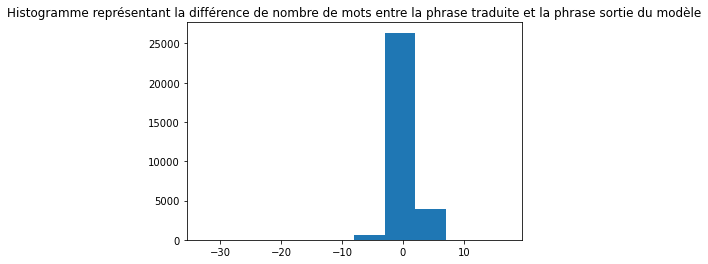

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(df_results.Différence)
plt.title("Histogramme représentant la différence de nombre de mots entre la phrase traduite et "
          "la phrase sortie du modèle");

In [102]:
print("La majorité des phrases sorties du modèle, soit", 
      round(len(df_results.loc[(df_results.Différence <= 1)&(df_results.Différence >= -1)])/df_results.shape[0]*100, 2),  
      "%, ne présente au plus qu'un mot d'écart avec la phrase traduite.")

La majorité des phrases sorties du modèle, soit 76.45 %, ne présente au plus qu'un mot d'écart avec la phrase traduite.


In [103]:
import nltk
from nltk.tokenize import word_tokenize
 
stop_words = set([",", ".", "?", "!", ":", ";"])

# Intialisation de la racinisation en français 
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

# Application à tout le dataframe 

# Instanciation des listes nécessaires 
racine_cible_tot=[]
racine_cible=[]
racine_mod_tot=[]
racine_mod=[]

# Création d'une colonne 'racine_cible' fournissant la liste des racines des mots des phrases de la colonne cible 
for sentence in df_results['Phrase_traduite']:
        # tokenisation des phrases en mots
    mots = word_tokenize(sentence, language='french')
    for mot in mots:
        # suppression des mots présents dans la liste stop_words 
        #if mot not in stop_words: 
        # racinisation des mots 
        racine_cible.append(stemmer.stem(mot))
    racine_cible_tot.append(racine_cible)
    racine_cible=[]
    
df_results['racine_cible']=racine_cible_tot

# rajout des guillemets 
df_results['racine_cible'] = [[f'"{j}"' for j in i] for i in df_results['racine_cible']]


# Création d'une colonne 'racine_mod' fournissant la liste des racines des mots des phrases de la colonne prédite 
#par le modèle  
for sentence in df_results['Sortie_modele']:
        # tokenisation des phrases en mots
    mots = word_tokenize(sentence, language='french')
    for mot in mots:
        # suppression des mots présents dans la liste stop_words 
        #if mot not in stop_words: 
        # racinisation des mots 
        racine_mod.append(stemmer.stem(mot))
    racine_mod_tot.append(racine_mod)
    racine_mod=[]

df_results['racine_mod']=racine_mod_tot

# rajout des guillemets 
df_results['racine_mod'] = [[f'"{j}"' for j in i] for i in df_results['racine_mod']]

df_results.head()

,Phrase_a_traduire,Phrase_traduite,Sortie_modele,nb_words_cible,nb_words_mod,Différence,racine_cible,racine_mod
0,you are old enough to know better than to act ...,tu es assez âgée pour savoir qu'il ne faut pas...,tu es assez âgée pour savoir que de prendre co...,12,11,1,"[""tu"", ""e"", ""assez"", ""âgé"", ""pour"", ""savoir"", ...","[""tu"", ""e"", ""assez"", ""âgé"", ""pour"", ""savoir"", ..."
1,all the money was spent on clothes,tout l'argent a été dépensé dans des vêtements,tout l'argent a été passé à des vêtements,8,8,0,"[""tout"", ""l'argent"", ""a"", ""été"", ""dépens"", ""da...","[""tout"", ""l'argent"", ""a"", ""été"", ""pass"", ""à"", ..."
2,he got off the train,il descendit du train,il a éteint le train,4,5,-1,"[""il"", ""descend"", ""du"", ""train""]","[""il"", ""a"", ""éteint"", ""le"", ""train""]"
3,have you ever been run over,avez vous jamais été renversée,as tu jamais été au courant,5,6,-1,"[""avez"", ""vous"", ""jam"", ""été"", ""renvers""]","[""as"", ""tu"", ""jam"", ""été"", ""au"", ""cour""]"
4,are you sure you can handle this,êtes vous sûrs de pouvoir gérer ceci,êtes vous sûres de pouvoir gérer ceci,7,7,0,"[""ête"", ""vous"", ""sûr"", ""de"", ""pouvoir"", ""ger"",...","[""ête"", ""vous"", ""sûr"", ""de"", ""pouvoir"", ""ger"",..."


In [104]:
# Création d'une colonne "comparaison racine" fournissant le ratio 
#nombre de racines en commun / nombre de racines des phrases cibles

# Création d'une colonne "comparaison différence" fournissant le ratio 
#différence du nombre de mots / nombre de mots cibles

score_racine=[]
score_difference = []
for i in range(df_results.shape[0]):
    score_racine.append(len(set(df_results.iloc[i,6]) & set(df_results.iloc[i,7]))/len(df_results.iloc[i,6]))
    if (abs(df_results.iloc[i, 5])/df_results.iloc[i,3]) > 1:
        score_diff = 0
    else :
        score_diff = 1 - abs(df_results.iloc[i, 5])/df_results.iloc[i,3]
    score_difference.append(score_diff)
    
df_results['score_racine']=score_racine

df_results['score_diff']= score_difference

df_results['score_tot']=(df_results['score_diff']+ df_results['score_racine'])/2


In [105]:
df_results = df_results.drop(["nb_words_cible", "nb_words_mod", "Différence", "racine_cible", "racine_mod"], axis = 1)
df_results.head()

,Phrase_a_traduire,Phrase_traduite,Sortie_modele,score_racine,score_diff,score_tot
0,you are old enough to know better than to act ...,tu es assez âgée pour savoir qu'il ne faut pas...,tu es assez âgée pour savoir que de prendre co...,0.50,0.916667,0.708333
1,all the money was spent on clothes,tout l'argent a été dépensé dans des vêtements,tout l'argent a été passé à des vêtements,0.75,1.000000,0.875000
2,he got off the train,il descendit du train,il a éteint le train,0.50,0.750000,0.625000
3,have you ever been run over,avez vous jamais été renversée,as tu jamais été au courant,0.40,0.800000,0.600000
4,are you sure you can handle this,êtes vous sûrs de pouvoir gérer ceci,êtes vous sûres de pouvoir gérer ceci,1.00,1.000000,1.000000


In [106]:
# Calcul de la moyenne du score_tot

print("moyenne du score_racine", df_results['score_racine'].mean())
print("moyenne du score_diff", df_results['score_diff'].mean())
print("Score du modèle au test de performance", df_results['score_tot'].mean())

moyenne du score_racine 0.653370213905087
moyenne du score_diff 0.8589311233082378
Score du modèle au test de performance 0.7561506686066941


Ce modèle présente un score de 75% au test de performance, ce qui n'est pas négligeable.
Cependant, d'autres méthodes de scoring existent, largement diffusées et appliquées aux travaux de traduction notamment.
Il s'agit des scores BLEU et ROUGE.

Il sera intéressant de comparer ces deux méthodes à ce test de performance afin de valider le score obtenu.

### Score BLEU

Le score BLEU (Bilingual Evaluation Understudy Score) est le score de référence pour évaluer les traductions émises par les systèmes de traductions automatiques (phreses candidates) par rapport à des phrases traduites dites de référence.
Ce score a été mis en place par les travaux de Kishore Papineni, et al. en 2002 dans “BLEU: a Method for Automatic Evaluation of Machine Translation“.

Il permet de calculer un ratio des n-grams communs aux phrases candidates et de référence sur les n-grams présents dans les références (n-grams représentant des groupes de tokens de n tokens) sans distinction d'ordre, et ressort un score compris entre 0 et 1, un score de 1 constituant une correspondance parfaite.

En affectant des poids sur les n premiers niveaux de n-grams, on peut obtenir des scores individuels n-grams lorsque l'intégralité des poids est affectée au niveau d'un unique niveau n de n-grams, et des scores cumulatifs n-grams lorsque les poids sont affectés sur plusieurs niveaux n de n-grams (le score représente alors la moyenne géométrique des scores de chaque niveau). Par défaut, les poids de la fonction utilisée (sentence_bleu) sont de 0.25 sur chacun des niveau de 1-gram à 4-gram.

Dans le cas de notre jeu de données, sachant que certaines phrases du corpus ne sont constituées que d'un seul mots, nous allons appliquer un score BLEU individual 1-gram (weights = (1, 0, 0, 0)).

In [107]:
from nltk.translate.bleu_score import sentence_bleu
score_bleu = []
for i in range(df_results.shape[0]):
    reference = [''.join(df_results.iloc[i, 1]).split()]
    candidate = ''.join(df_results.iloc[i, 2]).split()
    score_bleu.append(sentence_bleu(reference, candidate, weights = (1,0,0,0)))
df_results["Score_bleu"] = score_bleu
df_results.head()

C:\Users\mhedh\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\mhedh\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\mhedh\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin

,Phrase_a_traduire,Phrase_traduite,Sortie_modele,score_racine,score_diff,score_tot,Score_bleu
0,you are old enough to know better than to act ...,tu es assez âgée pour savoir qu'il ne faut pas...,tu es assez âgée pour savoir que de prendre co...,0.50,0.916667,0.708333,0.498055
1,all the money was spent on clothes,tout l'argent a été dépensé dans des vêtements,tout l'argent a été passé à des vêtements,0.75,1.000000,0.875000,0.750000
2,he got off the train,il descendit du train,il a éteint le train,0.50,0.750000,0.625000,0.400000
3,have you ever been run over,avez vous jamais été renversée,as tu jamais été au courant,0.40,0.800000,0.600000,0.333333
4,are you sure you can handle this,êtes vous sûrs de pouvoir gérer ceci,êtes vous sûres de pouvoir gérer ceci,1.00,1.000000,1.000000,0.857143


In [111]:
# Score BLEU du modèle : 
print("Score BLEU du modèle", df_results['Score_bleu'].mean())

Score BLEU du modèle 0.5992656185429632


### Score ROUGE

Le score ROUGE (Recall-Oriented Understudy for Gisting Evaluation) s'utilise principalement dans les travaux de resumés automatique de texte mais également pour les traductions automatiques. 
Comme pour le score BLEU, le but est de comparer la traduction du modèle à une traduction de référence, et la méthode peut s'utiliser sur différents niveaux de n-grams.

Ce score permet alors d'obtenir trois métriques : 
- le rappel (recall) qui se calcule par le ratio du nombre de n-grams commums aux deux phrases sur le nombre de n-grams dans la phrase de référence. Cela permet de juger si la traduction du modèle contient bien l'ensemble des mots de la phrase de référence. 
Cependant, cette métrique seule ne permettra pas de juger de la qualité de la traduction : en effet, le modèle peut ressortir des phrases très longues qui contiennet l'ensemble des mots de la référence sans que la traduction ne soit pertinente : la précision permet alors d'affiner la qualité de la traduction.
- la précision qui se calcule par le ratio du nombre de n-grams commums aux deux phrases sur le nombre de n-grams dans la traduction du modèle. Cela permet de juger de la pertinence des mots utilisés dans la traduction du modèle.
- le f1_score qui correspond à la moyenne harmonique des deux métriques précédentes.

Comme pour le score BLEU, on applique une score ROUGE-1 (sur 1-gram). On considère le f1_score comme le score ROUGE du modèle.

In [109]:
from rouge import Rouge

r = Rouge()
precision_col = []
recall_col = []
fscore_col = []

for i in range(df_results.shape[0]):
    reference = df_results.iloc[i, 1]
    candidate = df_results.iloc[i, 2]
    score_rouge = r.get_scores(candidate, reference)
    precision_col.append(score_rouge[0]['rouge-1']['p'])
    recall_col.append(score_rouge[0]['rouge-1']['r'])
    fscore_col.append(score_rouge[0]['rouge-1']['f'])

df_results['Rouge_recall'] = recall_col
df_results['Rouge_precision'] = precision_col
df_results['Rouge_f1_score'] = fscore_col

In [112]:
# Score ROUGE du modèle : 
print("Score ROUGE recall du modèle", df_results['Rouge_recall'].mean())
print("Score ROUGE precision du modèle", df_results['Rouge_precision'].mean())
print("Score ROUGE f1_score du modèle", df_results['Rouge_f1_score'].mean())

Score ROUGE recall du modèle 0.6351053523108378
Score ROUGE precision du modèle 0.6462375986502044
Score ROUGE f1_score du modèle 0.6356379752715831


La méthode BLEU attribue un score de 60% au modèle alors que la méthode ROUGE lui attribue un score de 63% (la composante f1_score sert de score ROUGE global regroupant l'information du recall et de la précision).
Ces scores similaires contribuent à affirmer que le score du modèle serait de 60% environ.

Le premier aperçu du score grâce au test de performance, dont il ressort un score bien plus important que les scores ci-dessus, n'est pas assez précis pour servir de score unique.

In [113]:
df_results = df_results.drop(["score_racine", "score_diff", "Rouge_recall", "Rouge_precision"], axis = 1)

In [114]:
df_results.head()

,Phrase_a_traduire,Phrase_traduite,Sortie_modele,score_tot,Score_bleu,Rouge_f1_score
0,you are old enough to know better than to act ...,tu es assez âgée pour savoir qu'il ne faut pas...,tu es assez âgée pour savoir que de prendre co...,0.708333,0.498055,0.521739
1,all the money was spent on clothes,tout l'argent a été dépensé dans des vêtements,tout l'argent a été passé à des vêtements,0.875000,0.750000,0.750000
2,he got off the train,il descendit du train,il a éteint le train,0.625000,0.400000,0.444444
3,have you ever been run over,avez vous jamais été renversée,as tu jamais été au courant,0.600000,0.333333,0.363636
4,are you sure you can handle this,êtes vous sûrs de pouvoir gérer ceci,êtes vous sûres de pouvoir gérer ceci,1.000000,0.857143,0.857143
